In [1]:
import os
from typing import Any, Dict, Tuple

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from IPython.display import clear_output
from PIL import Image
from sklearn.metrics import (
    RocCurveDisplay,
    auc,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from torchvision import transforms
from tqdm.notebook import tqdm, trange

In [2]:
RANDOM_SEED = 0
torch.manual_seed(0)
torch.set_default_dtype(torch.float32)

# Dataset

# Load data from drive

In [3]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip -q /content/drive/MyDrive/deep_gen_course/dataset.zip -d /content

replace /content/dataset/proliv/10_CAM_C_01-03-2023_05-39-27-929.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Dataset class

In [5]:
def display(image: torch.Tensor):
    image = (image * 255).type(torch.int).transpose(0, 2)
    plt.imshow(image)

In [6]:
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self, split: str = "train", dataset_dir: str = "dataset", image_shape=None
    ):
        self.dataset_dir = dataset_dir
        self.split = split
        self.root_dir = os.path.join(self.dataset_dir, self.split)
        if split == "test":
            self.images_dir = os.path.join(self.root_dir, "imgs")
        else:
            self.images_dir = self.root_dir
        self.image_ids = [
            fname for fname in os.listdir(self.images_dir) if fname.endswith(".jpg")
        ]
        self.labels = self.load_labels()
        if image_shape:
            self.image_shape = image_shape
        else:
            self.image_shape = self.get_common_size()

    def load_labels(self):
        labels = {}
        labels_path = os.path.join(self.root_dir, "test_annotation.txt")
        if os.path.exists(labels_path):
            with open(labels_path) as f:
                lines = f.readlines()
            for line in lines:
                path, label = line.split()
                labels.update({path: int(label)})
        return labels

    def get_common_size(self):
        """Selects image size by percentile"""
        shapes = []
        for image_id in self.image_ids:
            image_path = os.path.join(self.images_dir, image_id)
            image = cv2.imread(image_path)
            shapes.append(image.shape)
        shapes = np.array(shapes)
        common_height = int(np.quantile(shapes[:, 0], 0.99))
        common_width = int(np.quantile(shapes[:, 1], 0.99))
        return common_height, common_width

    def resize(self, image):
        """Resizes images so that they are of the same size"""
        height, width = image.shape[:2]
        common_height, common_width = self.image_shape
        image = cv2.resize(image, (common_width, common_height))
        return image

    def __len__(self) -> int:
        return len(self.image_ids)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.images_dir, image_id)
        image = cv2.imread(image_path)
        # normalize pixels
        image = cv2.normalize(image, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        # resize image to fit into a data loader
        image = self.resize(image)
        image = torch.tensor(image)
        image = image.type(torch.float32)
        # make channels dimension first
        image = image.transpose(0, 2)
        label = self.labels.get(image_id, 0)
        return image, label

In [7]:
train_dataset = Dataset("train")
proliv_dataset = Dataset("proliv", image_shape=train_dataset.image_shape)
test_dataset = Dataset("test", image_shape=train_dataset.image_shape)
train_dataset[0];

## Visualization

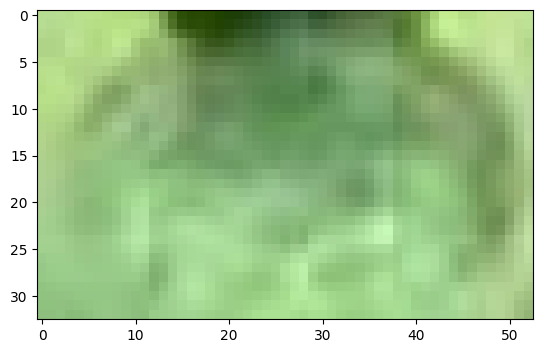

In [8]:
display(train_dataset[0][0])

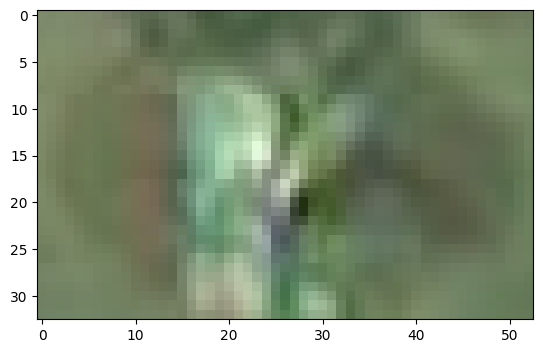

In [9]:
display(proliv_dataset[0][0])

## Data loaders

In [10]:
from torch.utils.data import DataLoader, SubsetRandomSampler

SPLIT_RATIO = 0.05
BATCH_SIZE = 128

val_split = int(np.floor(SPLIT_RATIO * len(train_dataset)))
indices = list(range(len(train_dataset)))
np.random.seed(RANDOM_SEED)
np.random.shuffle(indices)
train_sampler = SubsetRandomSampler(indices[val_split:])
val_sampler = SubsetRandomSampler(indices[:val_split])

# loader to train the model
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
# loader to choose a threshold
val_loader = DataLoader(train_dataset, batch_size=1, sampler=val_sampler)

# proliv loader to choose a threshold
proliv_loader = DataLoader(proliv_dataset, batch_size=1, shuffle=False)
# loader to estimate the pipeline
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [11]:
next(iter(train_loader))[0].shape

torch.Size([128, 3, 53, 33])

# Models

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Autoencoder

In [13]:
class Encoder(nn.Module):
    def __init__(self, input_dims, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(input_dims, 512)
        self.linear2 = nn.Linear(512, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        return self.linear2(x)

In [14]:
class Decoder(nn.Module):
    def __init__(self, out_dims, latent_dims, shape):
        super(Decoder, self).__init__()
        self.shape = shape
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, out_dims)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, *self.shape))

In [15]:
class Autoencoder(nn.Module):
    def __init__(self, shape, latent_dims):
        super(Autoencoder, self).__init__()
        self.shape = shape
        self.latent_dims = latent_dims
        self.input_dims = torch.prod(torch.tensor(self.shape))
        self.encoder = Encoder(self.input_dims, self.latent_dims)
        self.decoder = Decoder(self.input_dims, self.latent_dims, self.shape)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [16]:
latent_dims = 2
shape = next(iter(train_loader))[0].shape
autoencoder = Autoencoder(shape[1:], latent_dims)

In [17]:
autoencoder(next(iter(train_loader))[0]);

## VAE

In [18]:
class VariationalEncoder(nn.Module):
    def __init__(self, input_dims, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(input_dims, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device)  # hack to get sampling on the GPU
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu = self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma * self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1 / 2).sum()
        return z


class VariationalAutoencoder(nn.Module):
    def __init__(self, shape, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.shape = shape
        self.latent_dims = latent_dims
        self.input_dims = torch.prod(torch.tensor(self.shape))
        self.encoder = VariationalEncoder(self.input_dims, self.latent_dims)
        self.decoder = Decoder(self.input_dims, self.latent_dims, self.shape)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

In [19]:
vae = VariationalAutoencoder(shape[1:], latent_dims).to(device)

In [20]:
vae(next(iter(train_loader))[0].to(device));

# Training

In [21]:
def run_epoch(model, data, mode="train", opt=None, show_pb=True):
    epoch_losses = []
    if show_pb:
        batches = tqdm(data)
    else:
        batches = data
    for x, y in batches:
        x = x.to(device)  # GPU
        if mode == "train":
            opt.zero_grad()
        x_hat = model(x)
        loss = ((x - x_hat) ** 2).sum() / data.batch_size
        epoch_losses.append(loss.item())
        if show_pb:
            batches.set_description(str(loss.item()))
        if mode == "train" and opt:
            loss.backward()
            opt.step()
    return epoch_losses


def train(model, data, lr=0.001, epochs=20, plot=True, pb_for_each_epoch=True):
    model.to(device)
    model.train()
    loss_history = []
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    if not pb_for_each_epoch:
        epochs_range = trange(epochs)
    else:
        epochs_range = range(epochs)
    for epoch in epochs_range:
        if pb_for_each_epoch:
            print(f"Epoch: {epoch}")
        epoch_losses = run_epoch(
            model, data, mode="train", opt=opt, show_pb=pb_for_each_epoch
        )
        avg_epoch_loss = np.mean(epoch_losses)
        loss_history.append(avg_epoch_loss)
        if not pb_for_each_epoch:
            epochs_range.set_description(str(avg_epoch_loss))
        elif not plot:
            print(f"Train loss: {avg_epoch_loss}")

        if plot:
            clear_output()
            print(f"Train loss: {avg_epoch_loss}")
            print("Loss curve")
            plt.plot(loss_history)
            plt.show()

    return model, loss_history


def eval(model, data):
    model.eval()
    losses = run_epoch(model, data, mode="eval")
    return losses

Train loss: 31.254101575215657
Loss curve


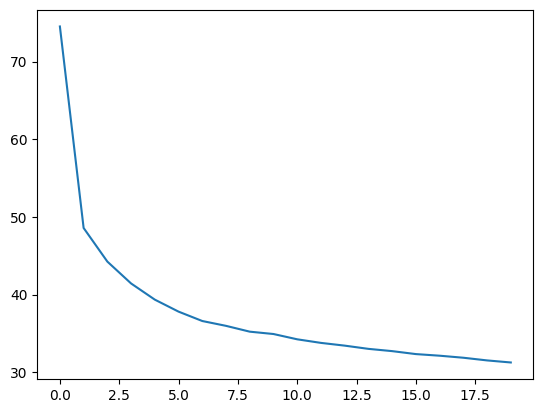

In [22]:
autoencoder, loss_history = train(autoencoder, train_loader)

Some visualisation.

In [23]:
def visualize(model, batch):
    model.to("cpu")
    batch.to("cpu")
    display(batch[0])
    plt.show()
    model.eval()
    with torch.no_grad():
        output = model(batch)[0]
        display(output)
        loss = ((batch - output) ** 2).sum()
        print(f"Loss: {loss:.2f}")

No proliv example


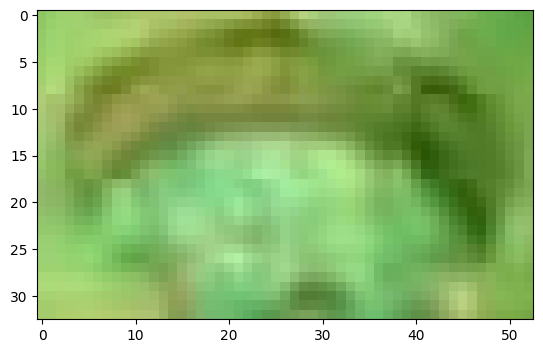

Loss: 30.59


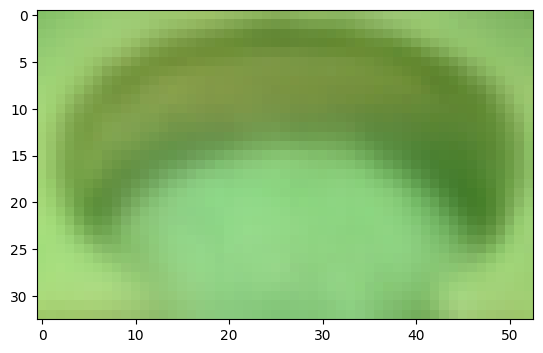

In [24]:
batch = next(iter(val_loader))[0]
print("No proliv example")
visualize(autoencoder, batch)

Proliv example


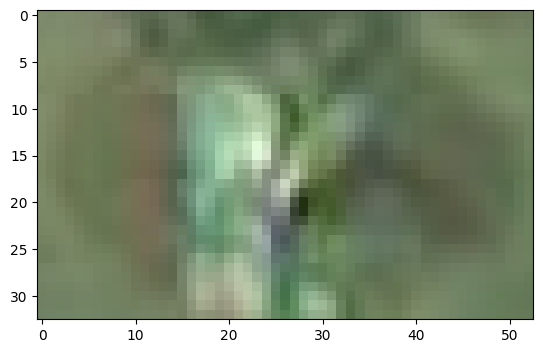

Loss: 102.21


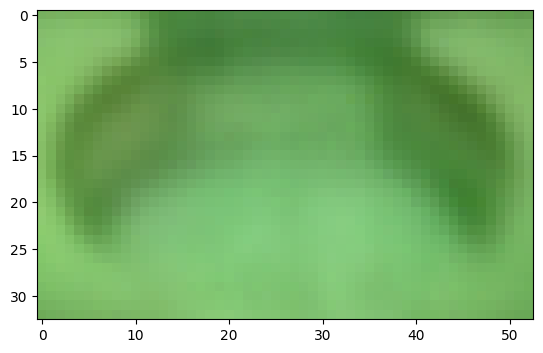

In [25]:
batch = next(iter(proliv_loader))[0]
print("Proliv example")
visualize(autoencoder, batch)

In [26]:
def compute_metrics(y_true, losses, th):
    y_pred = [1 if loss > th else 0 for loss in losses]
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    roc_auc = roc_auc_score(y_true, y_pred)
    return tpr, tnr, roc_auc

In [27]:
def choose_threshold(model, val_loader, proliv_loader, plot=True):
    model.to(device)
    val_losses = eval(model, val_loader)
    proliv_losses = eval(model, proliv_loader)
    y_true = np.hstack((np.zeros(len(val_losses)), np.ones(len(proliv_losses))))
    losses = np.hstack((val_losses, proliv_losses))
    fpr, tpr, thresholds = roc_curve(np.array(y_true), losses)
    roc_auc = auc(fpr, tpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    if plot:
        display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
        display.plot()
        plt.show()
    tpr, tnr, roc_auc = compute_metrics(y_true, losses, optimal_threshold)
    return optimal_threshold, tpr, tnr, roc_auc

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

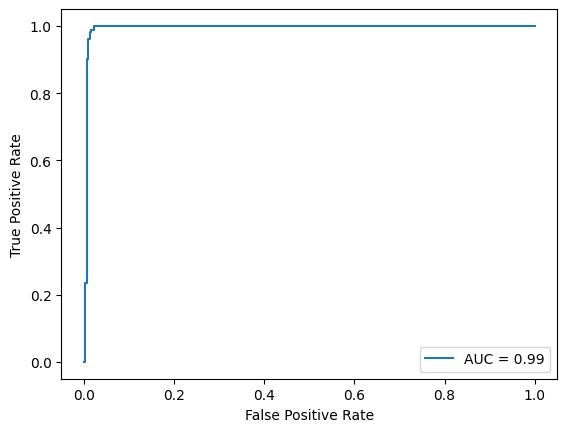

(69.76402282714844, 0.987012987012987, 0.978, 0.9825064935064934)

In [28]:
choose_threshold(autoencoder, val_loader, proliv_loader)

In [29]:
def test_eval(model, data, y_true, th):
    losses = run_epoch(model, data, mode="eval")
    y_pred = [1 if loss > th else 0 for loss in losses]
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    roc_auc = roc_auc_score(y_true, y_pred)
    return tpr, tnr, roc_auc

# Hyperparameter tuning

In [30]:
!pip install optuna

In [31]:
def objective(trial):
    model = trial.suggest_categorical("model", ["AE", "VAE"])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    epochs = trial.suggest_int("epochs", 10, 50)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128, 256])
    latent_dims = trial.suggest_categorical("latent_dims", [2, 4, 8, 16, 32, 64])

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler
    )
    shape = next(iter(train_loader))[0].shape
    if model == "AE":
        model = Autoencoder(shape[1:], latent_dims)
    elif model == "VAE":
        model = VariationalAutoencoder(shape[1:], latent_dims)
    model.to(device)

    model, loss_history = train(
        model,
        train_loader,
        lr=learning_rate,
        epochs=epochs,
        plot=False,
        pb_for_each_epoch=False,
    )
    th, _, _, _ = choose_threshold(model, val_loader, proliv_loader, plot=False)
    y_true = [int(b[1]) for b in list(test_loader)]
    tpr, tnr, roc_auc = test_eval(model, test_loader, y_true, th)
    return roc_auc

In [32]:
import optuna
from optuna.samplers import TPESampler

optuna.logging.set_verbosity(optuna.logging.INFO)

sampler = TPESampler(seed=1)
study = optuna.create_study(
    study_name="proliv-detection", direction="maximize", sampler=sampler
)
study.optimize(objective, n_trials=20)

[I 2024-02-21 08:50:49,986] A new study created in memory with name: proliv-detection


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/3794 [00:00<?, ?it/s]

[I 2024-02-21 08:51:56,328] Trial 0 finished with value: 0.7044407077212687 and parameters: {'model': 'VAE', 'learning_rate': 1.0005268542378301e-05, 'epochs': 22, 'batch_size': 256, 'latent_dims': 64}. Best is trial 0 with value: 0.7044407077212687.


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/3794 [00:00<?, ?it/s]

[I 2024-02-21 08:53:05,572] Trial 1 finished with value: 0.8783273581014627 and parameters: {'model': 'VAE', 'learning_rate': 6.832971428089606e-05, 'epochs': 32, 'batch_size': 256, 'latent_dims': 16}. Best is trial 1 with value: 0.8783273581014627.


  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/3794 [00:00<?, ?it/s]

[I 2024-02-21 08:54:21,385] Trial 2 finished with value: 0.881248347557558 and parameters: {'model': 'VAE', 'learning_rate': 1.57287303724872e-05, 'epochs': 27, 'batch_size': 32, 'latent_dims': 32}. Best is trial 2 with value: 0.881248347557558.


  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/3794 [00:00<?, ?it/s]

[I 2024-02-21 08:55:43,162] Trial 3 finished with value: 0.8519898050911092 and parameters: {'model': 'VAE', 'learning_rate': 1.6086146261367402e-05, 'epochs': 28, 'batch_size': 32, 'latent_dims': 4}. Best is trial 2 with value: 0.881248347557558.


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/3794 [00:00<?, ?it/s]

[I 2024-02-21 08:56:55,576] Trial 4 finished with value: 0.8855653203887601 and parameters: {'model': 'AE', 'learning_rate': 0.0001508728428893204, 'epochs': 38, 'batch_size': 128, 'latent_dims': 32}. Best is trial 4 with value: 0.8855653203887601.


  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/3794 [00:00<?, ?it/s]

[I 2024-02-21 08:58:19,807] Trial 5 finished with value: 0.8492856160834206 and parameters: {'model': 'AE', 'learning_rate': 1.8991212552914026e-05, 'epochs': 43, 'batch_size': 128, 'latent_dims': 8}. Best is trial 4 with value: 0.8855653203887601.


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/3794 [00:00<?, ?it/s]

[I 2024-02-21 08:59:54,373] Trial 6 finished with value: 0.8753259938449824 and parameters: {'model': 'VAE', 'learning_rate': 7.180957886080998e-05, 'epochs': 49, 'batch_size': 256, 'latent_dims': 32}. Best is trial 4 with value: 0.8855653203887601.


  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/3794 [00:00<?, ?it/s]

[I 2024-02-21 09:01:02,600] Trial 7 finished with value: 0.8642437894603255 and parameters: {'model': 'VAE', 'learning_rate': 4.5008009194793744e-05, 'epochs': 31, 'batch_size': 128, 'latent_dims': 16}. Best is trial 4 with value: 0.8855653203887601.


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/3794 [00:00<?, ?it/s]

[I 2024-02-21 09:02:25,662] Trial 8 finished with value: 0.8849878909017842 and parameters: {'model': 'AE', 'learning_rate': 1.3551904902887622e-05, 'epochs': 40, 'batch_size': 64, 'latent_dims': 32}. Best is trial 4 with value: 0.8855653203887601.


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/3794 [00:00<?, ?it/s]

[I 2024-02-21 09:03:22,286] Trial 9 finished with value: 0.8992396120858318 and parameters: {'model': 'VAE', 'learning_rate': 1.7715223269967092e-05, 'epochs': 21, 'batch_size': 64, 'latent_dims': 32}. Best is trial 9 with value: 0.8992396120858318.


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/3794 [00:00<?, ?it/s]

[I 2024-02-21 09:03:53,666] Trial 10 finished with value: 0.8191577566970187 and parameters: {'model': 'AE', 'learning_rate': 0.0005665906711012519, 'epochs': 10, 'batch_size': 64, 'latent_dims': 2}. Best is trial 9 with value: 0.8992396120858318.


  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/3794 [00:00<?, ?it/s]

[I 2024-02-21 09:04:34,827] Trial 11 finished with value: 0.8804054697166789 and parameters: {'model': 'AE', 'learning_rate': 0.00029122286945701577, 'epochs': 16, 'batch_size': 128, 'latent_dims': 32}. Best is trial 9 with value: 0.8992396120858318.


  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/3794 [00:00<?, ?it/s]

[I 2024-02-21 09:05:56,948] Trial 12 finished with value: 0.8266199223748638 and parameters: {'model': 'AE', 'learning_rate': 0.00021142842386958794, 'epochs': 38, 'batch_size': 64, 'latent_dims': 32}. Best is trial 9 with value: 0.8992396120858318.


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/3794 [00:00<?, ?it/s]

[I 2024-02-21 09:06:48,512] Trial 13 finished with value: 0.874812018147784 and parameters: {'model': 'AE', 'learning_rate': 0.00016192157837349472, 'epochs': 21, 'batch_size': 64, 'latent_dims': 2}. Best is trial 9 with value: 0.8992396120858318.


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/3794 [00:00<?, ?it/s]

[I 2024-02-21 09:08:04,858] Trial 14 finished with value: 0.8569011284198949 and parameters: {'model': 'VAE', 'learning_rate': 3.828369253965047e-05, 'epochs': 35, 'batch_size': 128, 'latent_dims': 4}. Best is trial 9 with value: 0.8992396120858318.


  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/3794 [00:00<?, ?it/s]

[I 2024-02-21 09:09:38,517] Trial 15 finished with value: 0.7608458390177353 and parameters: {'model': 'AE', 'learning_rate': 0.000604866285790578, 'epochs': 45, 'batch_size': 64, 'latent_dims': 64}. Best is trial 9 with value: 0.8992396120858318.


  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/3794 [00:00<?, ?it/s]

[I 2024-02-21 09:10:32,146] Trial 16 finished with value: 0.8549911693475893 and parameters: {'model': 'AE', 'learning_rate': 0.00012555817482865655, 'epochs': 23, 'batch_size': 128, 'latent_dims': 8}. Best is trial 9 with value: 0.8992396120858318.


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/3794 [00:00<?, ?it/s]

[I 2024-02-21 09:11:30,270] Trial 17 finished with value: 0.8786562602451432 and parameters: {'model': 'VAE', 'learning_rate': 3.752635942196769e-05, 'epochs': 17, 'batch_size': 32, 'latent_dims': 32}. Best is trial 9 with value: 0.8992396120858318.


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/3794 [00:00<?, ?it/s]

[I 2024-02-21 09:12:10,537] Trial 18 finished with value: 0.8867931512209567 and parameters: {'model': 'VAE', 'learning_rate': 0.0003381746038855824, 'epochs': 11, 'batch_size': 64, 'latent_dims': 32}. Best is trial 9 with value: 0.8992396120858318.


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/3794 [00:00<?, ?it/s]

[I 2024-02-21 09:12:51,464] Trial 19 finished with value: 0.8902841672218873 and parameters: {'model': 'VAE', 'learning_rate': 0.0004004957736376805, 'epochs': 11, 'batch_size': 64, 'latent_dims': 32}. Best is trial 9 with value: 0.8992396120858318.


In [33]:
study.best_trial.params

{'model': 'VAE',
 'learning_rate': 1.7715223269967092e-05,
 'epochs': 21,
 'batch_size': 64,
 'latent_dims': 32}

Train loss: 25.622249801686944
Loss curve


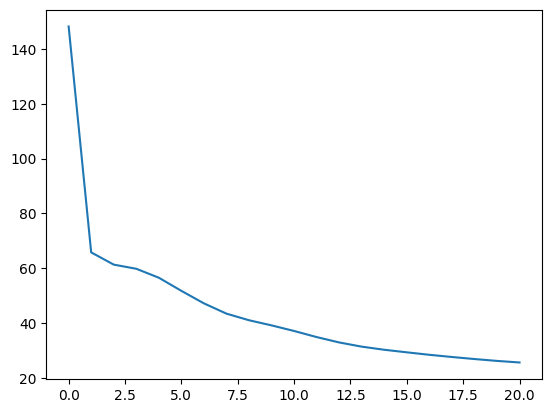

Choosing threshold on validation set ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/154 [00:00<?, ?it/s]

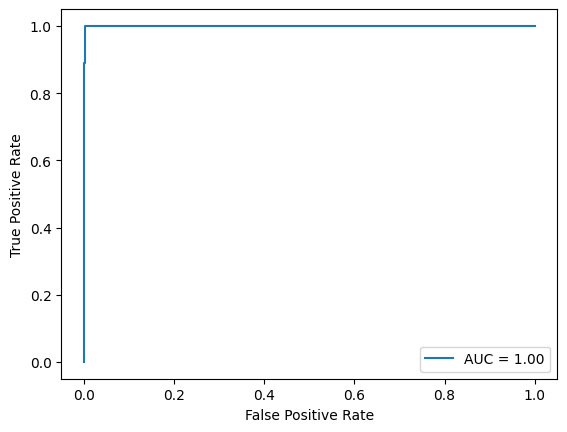

Evaluation on the test set ...


  0%|          | 0/3794 [00:00<?, ?it/s]

True Positive rate 0.860
True Neagtive rate: 0.928
ROC AUC score: 0.894


In [34]:
_, learning_rate, epochs, batch_size, latent_dims = study.best_trial.params.values()

train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
shape = next(iter(train_loader))[0].shape
model = VariationalAutoencoder(shape[1:], latent_dims)
model.to(device)

model, loss_history = train(model, train_loader, lr=learning_rate, epochs=epochs)
print("Choosing threshold on validation set ...")
th, _, _, _ = choose_threshold(model, val_loader, proliv_loader)
print("Evaluation on the test set ...")
y_true = [int(b[1]) for b in list(test_loader)]
tpr, tnr, roc_auc = test_eval(model, test_loader, y_true, th)
print(
    f"True Positive rate {tpr:.3f}\nTrue Neagtive rate: {tnr:.3f}\nROC AUC score: {roc_auc:.3f}"
)